In [4]:
#all imports here

from nilearn import plotting, image
import nibabel as nib
import os
import numpy as np
from pathlib import Path
import tarfile
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#loading the data
sub_list = os.listdir("HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2")
make_path = lambda x: "HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2" + "/" + x

paths = [make_path(i) for i in sub_list]
sub_data = [np.loadtxt(path) for path in paths]

### EDA on Single Subject

In [23]:
#get data for one subject
X = sub_data[1]
X.shape #(data points, brain regions)

(4800, 100)

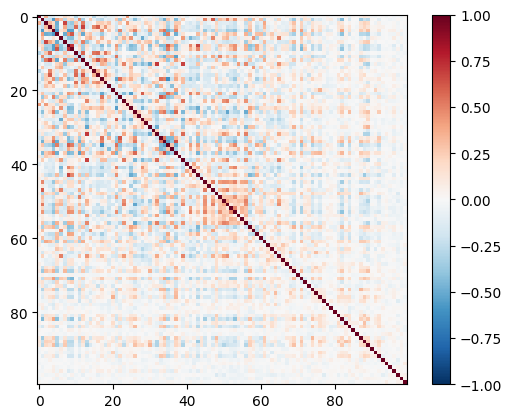

In [24]:
cov_matrix = np.corrcoef(X.T)
plt.imshow(cov_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

In [25]:
#lets plot it on the brain

atlas = image.load_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz")
atlas = image.threshold_img(atlas, "99.5%") 
print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)

atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)

# plotting.plot_connectome(cov_matrix, atlas_coords, edge_threshold="99.9%")

atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10e9bcdd0>>
Traceback (most recent call last):
  File "/Users/anastasiyamarkova/anaconda3/envs/capstone/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [26]:
#lets check the 99.9 percentile
def percentile(cov_matrix, percentile=99.9):
    ''' 
    find percentile

    Takes in:
    cov_matrix
    percentile = 99.9
    '''
    cov_matrix = np.array(cov_matrix)
    iu = np.triu_indices(100, 1) #get the upper triangle and and offset it to not include the diagonal
    unique_cov = abs(cov_matrix[iu])
    threshold = np.percentile(unique_cov, percentile) #threshold for 99.9 percentile
    indices = np.where((cov_matrix >= threshold) & (cov_matrix <0.999))
    pairs = np.dstack(indices)
    unique_pairs = np.array(list({tuple(np.sort(row)) for row in pairs[0]}))
    strong_correlations = {(x, y):cov_matrix[x, y] for x, y in unique_pairs}
    return strong_correlations

In [27]:
percentile(cov_matrix)

{(np.int64(2), np.int64(7)): np.float64(0.6667103800859483),
 (np.int64(13), np.int64(39)): np.float64(0.6760047235995437),
 (np.int64(13), np.int64(32)): np.float64(0.706674930166747),
 (np.int64(8), np.int64(9)): np.float64(0.7218967428042317),
 (np.int64(3), np.int64(12)): np.float64(0.6808306576203431)}

### Sliding Windows

In [28]:
def sliding_windows(data, num_windows, create_figure=False):
    len_window = 4800//num_windows
    window_matrices = []
    if create_figure:
        fig, axs = plt.subplots(num_windows//4, 4, figsize=(15, 10))
    for i in range(num_windows):
        row = i//4
        col = i % 4
        i = int(i*len_window//2)
        lil_data = data[i: i + len_window]
        sub_corr_matrix = np.corrcoef(lil_data.T)
        window_matrices.append(sub_corr_matrix) 
        if create_figure:
            img = axs[row][col].imshow(sub_corr_matrix, cmap="RdBu_r",vmin=-1, vmax=1, interpolation="none")
        # axs[row][col].title(f"corr graph in window {i} to {i+len_5_min}")
        #plt.show()
    if create_figure:
        fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, shrink = 0.4)
    return window_matrices

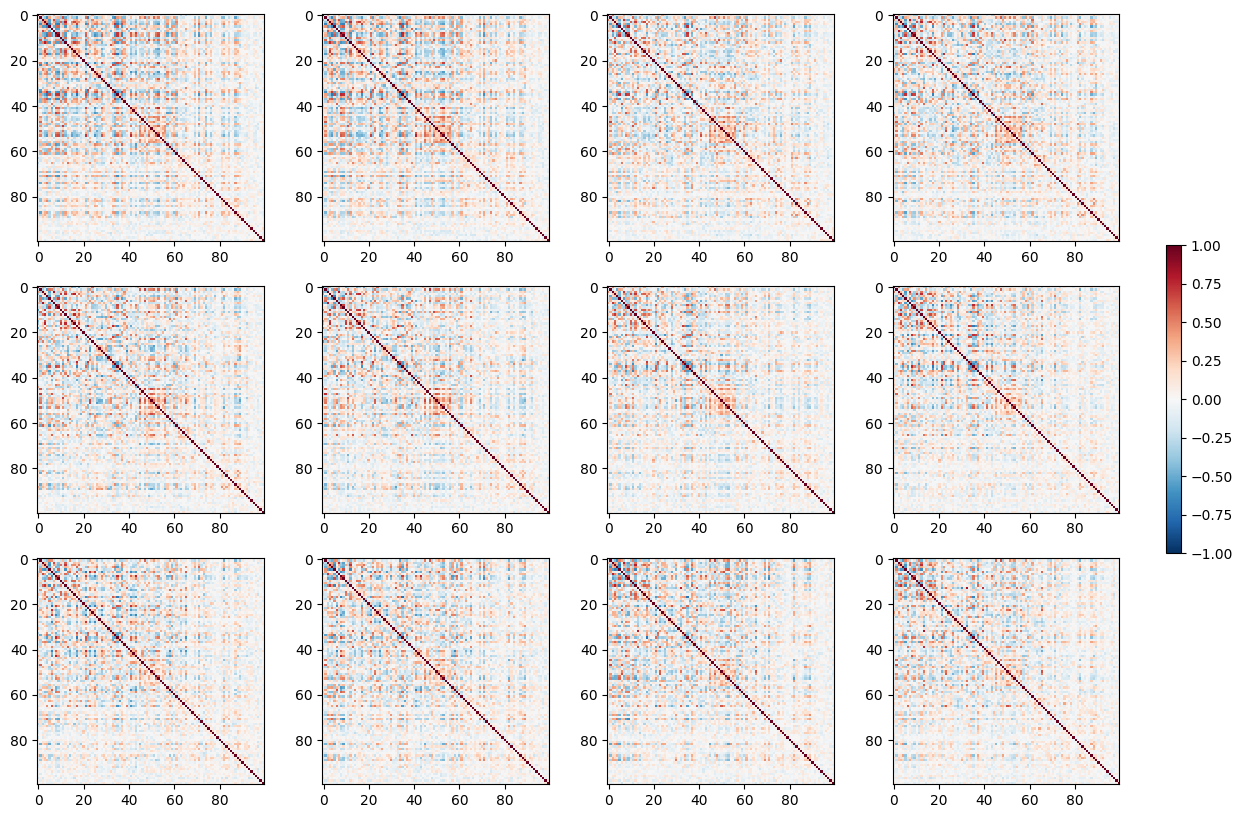

In [31]:
num_windows = 12
data = X
windows12 = sliding_windows(data, num_windows, True)

In [163]:
# for mat in windows12:
#     print(percentile(mat).keys())
#     plotting.plot_connectome(mat, atlas_coords, edge_threshold="99.9%")
#     plt.show()
#plot brain connectivities for each matrix
#colors represent the strengths of the connections

In [29]:
def get_data_over_time(matrices, x, y):
    data = np.array(matrices)[:, x, y]
    data = pd.DataFrame({
        'x': range(1, len(data) + 1),  # Generate x-axis values (e.g., 1, 2, 3, ...)
        'y': data,
        'group':[f'({x},{y})']*len(data) # Use the list for y-axis values
    })
    return data
    
def plot_correlations_over_time(data):
    chart = alt.Chart(data).mark_point().encode(
    x=alt.X('x', title='Time Window'),
    y=alt.Y('y', title = 'Correlation'),
    color='group',
    tooltip=['x', 'y'],
    ).properties(title='Correlation over 12 windows', )
    return chart



In [60]:
def distance_between_coords(id1, id2):
    return np.sqrt(np.sum([(atlas_coords[id2][i] - atlas_coords[id1][i])**2 for i in range(3)]))

In [246]:
#distirbution of distances
dist = []
indices = np.triu_indices(100, 1)
for i, j in zip(*indices):
    dist.append(distance_between_coords(i, j))
df = pd.DataFrame({'dist':dist})
df.shape

In [250]:
#This is a distribution of all distance pairs excluding the diagonal
alt.Chart(df).mark_bar().encode(
    alt.X('dist:Q', bin=True),
    alt.Y('count()')
).properties(title='distribution of dist between 100 regions')

alt.Chart(...)

In [167]:
charts = {}
plot_data = {}
for mat in windows12:
    top_correlations = percentile(mat).keys()
    for x,y in top_correlations: 
        data = get_data_over_time(windows12, x, y)
        chart = plot_correlations_over_time(data)
        charts[(x, y)] = chart
        distance = distance_between_coords(x, y)
        plot_data[(x, y)] = [data, distance]

# combined_chart = alt.layer(*charts).interactive()
# combined_chart



In [168]:
combined_chart = alt.layer(*charts.values()).interactive()
combined_chart


alt.LayerChart(...)

In [39]:
data = pd.DataFrame({'x':[], 'y':[], 'group': []})
for mat in windows12:
    top_correlations = percentile(mat).keys()
    for x,y in top_correlations: 
        data = pd.concat((data, get_data_over_time(windows12, x, y)), axis=0)


In [40]:
data

x         y    group
0    1.0  0.782040   (3,12)
1    2.0  0.739812   (3,12)
2    3.0  0.701513   (3,12)
3    4.0  0.770979   (3,12)
4    5.0  0.717427   (3,12)
..   ...       ...      ...
7    8.0  0.682769  (21,28)
8    9.0  0.708720  (21,28)
9   10.0  0.614175  (21,28)
10  11.0  0.642875  (21,28)
11  12.0  0.651962  (21,28)

[648 rows x 3 columns]

In [74]:
alt.Chart(data, width=100).transform_density(
    'y',
    as_=['y', 'density'],
    extent=[0, 1],
    groupby=['x']
).mark_area(orient='horizontal').encode(
    alt.X('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    alt.Y('y:Q'),
    alt.Color('x:N'),
    alt.Column('x:N')
        .spacing(0)
        .header(titleOrient='bottom', labelOrient='bottom', labelPadding=0)
).configure_view(
    stroke=None
)

alt.Chart(...)

# !!!! need to fix

In [ ]:
# d = list(plot_data.values())[i][0]
#     x = d['x']
#     y = d['y']
# info = np.polyfit(x, y, 1, full=True)
# x = np.linspace(0, 10)
# y = m*x + b

# df = pd.DataFrame({'x': x, 'y': y})

# chart = alt.Chart(df).mark_point().encode(
#     x='x',
#     y='y'
# )

# chart + chart.transform_regression('x', 'y').mark_line()

indx = (17, 33)
charts[indx] #+ charts[indx].transform_regression('x', 'y').mark_line()

alt.Chart(...)

np.float64(1.0)

In [80]:
distances = []
df = pd.DataFrame({'x':[], 'y': [], 'cor':[], 'dist':[]})
for mat in windows12:
    top_correlations = percentile(mat, 99.9)
    top_correlations_id = top_correlations.keys()
    indices = np.triu_indices(100, 1)
    for x,y in zip(*indices):
        distance = distance_between_coords(x, y)
        distances.append(distance)
        df.loc[len(df)] = [x, y, mat[x][y], distance]
df.shape     

(59400, 4)

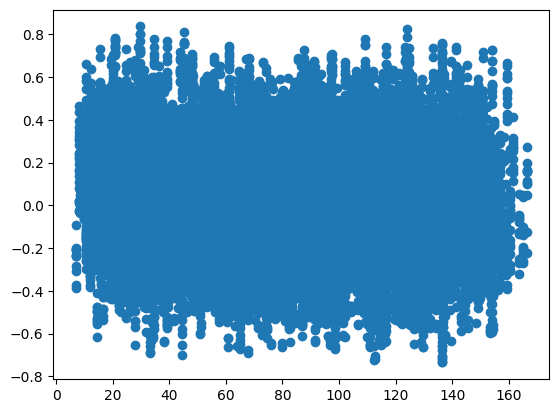

In [84]:
sample = df[df['cor'] > -1.0]
plt.scatter(x=sample['dist'], y=sample['cor'])

In [69]:
alt.Chart(df).mark_point().encode(
    alt.X('dist'),
    alt.Y('cor')
).interactive()

alt.Chart(...)

In [119]:
vals = list(plot_data.values())
slopes = []
res = []
dist = []
for i in range(len(vals)):
    d = vals[i][0]
    x = d['x']
    y = d['y']
    info = np.polyfit(x, y, 1, full=True)
    slopes.append(info[0][0])
    res.append(info[1][0])
    dist.append(vals[i][1])

In [144]:
x = np.array(list(plot_data.keys()))[:, 0]
y = np.array(list(plot_data.keys()))[:, 1]
slope_plot = pd.DataFrame({'slope':slopes, 'dist_xy': dist, 'x': x, 'y':y})
alt.Chart(slope_plot).mark_point().encode(
    x = alt.X('dist_xy'),
    y = alt.Y('slope'),
    tooltip = ['x', 'y']
)

alt.Chart(...)

In [145]:
x = np.array(list(plot_data.keys()))[:, 0]
y = np.array(list(plot_data.keys()))[:, 1]
slope_plot = pd.DataFrame({'res':res, 'dist_xy': dist, 'x': x, 'y':y})
alt.Chart(slope_plot).mark_point().encode(
    x = alt.X('dist_xy'),
    y = alt.Y('res'),
    tooltip = ['x', 'y']
)

alt.Chart(...)

In [155]:
x = np.array(list(plot_data.keys()))[:, 0]
y = np.array(list(plot_data.keys()))[:, 1]
slope_plot = pd.DataFrame({'res':res, 'slope': slopes, 'x': x, 'y':y})
alt.Chart(slope_plot).mark_point().encode(
    x = alt.X('slope'),
    y = alt.Y('res'),
    tooltip = ['x', 'y']
)

alt.Chart(...)

### PCA

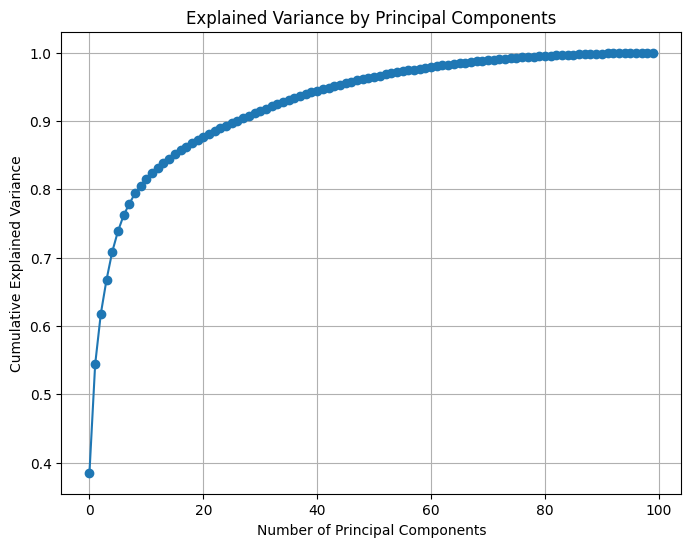

Number of components to explain 90% variance: 27


TypeError: 'PCA' object is not subscriptable

In [10]:
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA
pca = PCA()
correlation_matrix = np.zeros((100,100))
for i in sub_data:
    X = i
    correlation_matrix = correlation_matrix + np.corrcoef(X.T)
pca_data = pca.fit(correlation_matrix)

# Transform data to principal component space
# pca_data = pca.fit(sub_data)  # Shape: 4800 x 100

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

# Choose top k components (e.g., 90% variance explained)
k = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components to explain 90% variance: {k}")

# Extract top k components
top_k_pca_data = pca_data[:, :k]

In [12]:
pca.components_

array([[-5.11359634e-02, -1.80885829e-01,  1.16330297e-01, ...,
        -3.89758133e-05, -4.19859286e-02, -4.21888598e-02],
       [ 2.62966377e-03,  1.34541637e-01,  4.33456193e-02, ...,
        -2.88242447e-04, -3.09349364e-02, -2.19671497e-02],
       [ 1.25890253e-01,  6.88724229e-02,  1.38264243e-01, ...,
         1.85618403e-02, -1.66043209e-02, -2.07963788e-02],
       ...,
       [-1.53197556e-01, -1.89380678e-01,  1.37147535e-01, ...,
        -3.10553416e-02, -1.00208618e-02, -1.05251531e-02],
       [-1.90046989e-01, -1.60978631e-02,  1.90551020e-01, ...,
         2.44796563e-02,  9.13079260e-03,  6.43627483e-03],
       [ 2.76135765e-02,  1.70999168e-01,  1.59690644e-02, ...,
         1.40527707e-01,  1.30221683e-01,  1.11291280e-01]])

In [14]:
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)

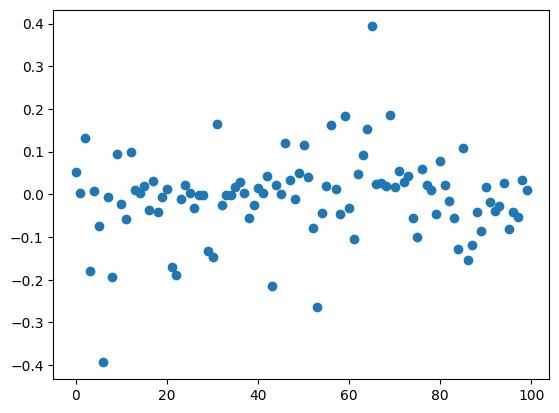

In [20]:
plt.scatter(x=range(100), y=eigenvectors[0])

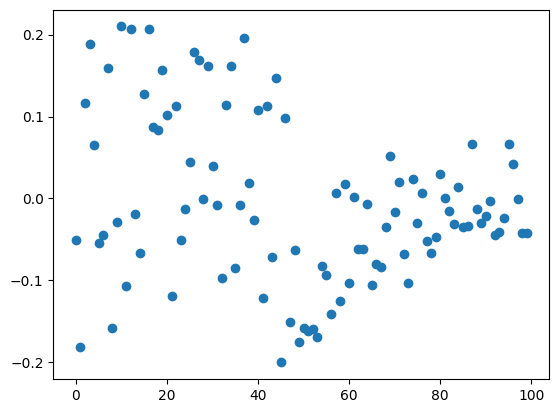

In [21]:
plt.scatter(range(100),pca.components_[0])

## Across Multiple Subjects

In [14]:
#sliding windows
correlations_sub = []
for sub in sub_data:
    mat = sliding_windows(sub, 12)
    correlations_sub.append(mat)

In [ ]:
# correlations_sub = np.array(correlations_sub)

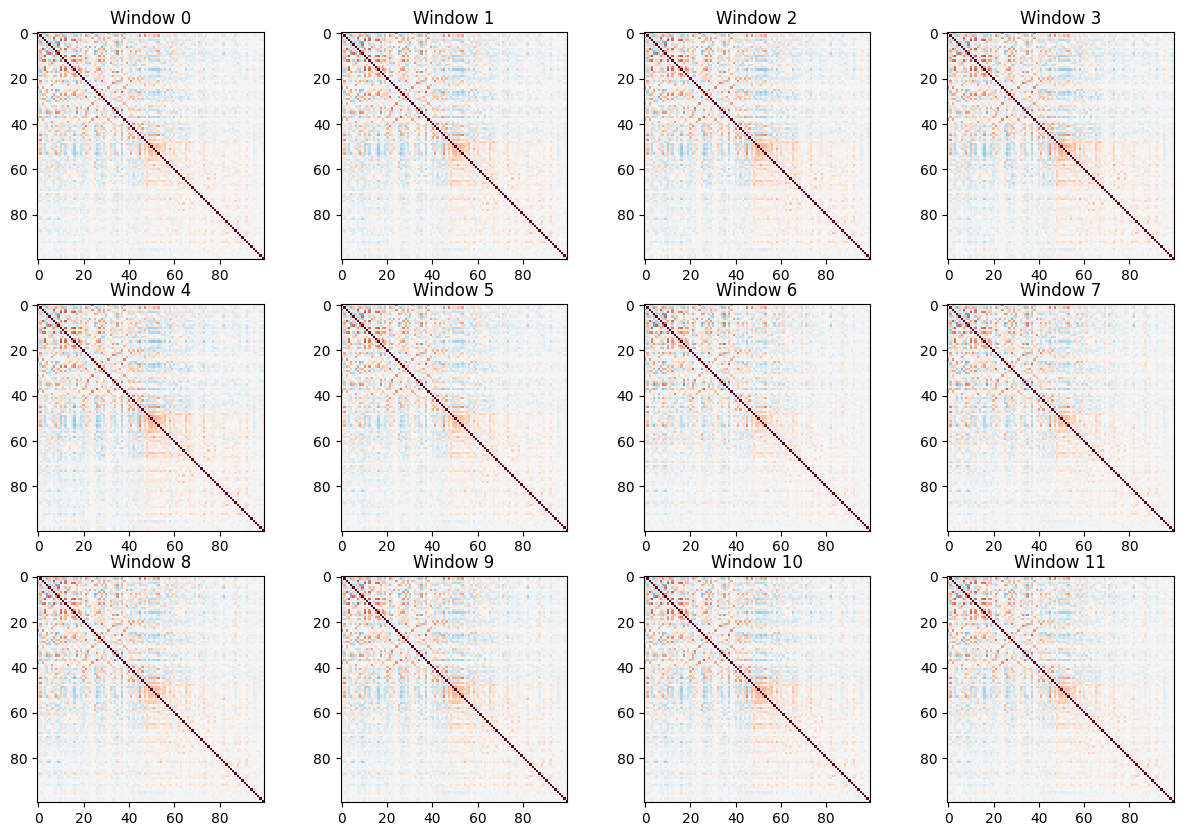

In [32]:
temp = np.mean(correlations_sub, axis=0)
num_windows = 12
len_window = 4800/num_windows
fig, axs = plt.subplots(num_windows//4, 4, figsize=(15, 10))
for i in range(num_windows):
    row = i//4
    col = i % 4
    img = axs[row][col].imshow(temp[i], cmap="RdBu_r",vmin=-1, vmax=1, interpolation="none")
    axs[row][col].set_title(f'Window {i}')

In [38]:
data = get_data_over_time(temp, 3, 10)
plot_correlations_over_time(data)

alt.Chart(...)

In [36]:
percentile(temp[0])

{(np.int64(2), np.int64(7)): np.float64(0.6019881471641029),
 (np.int64(3), np.int64(10)): np.float64(0.6462654501029417),
 (np.int64(10), np.int64(16)): np.float64(0.5906160659281136),
 (np.int64(10), np.int64(12)): np.float64(0.5905197463370682),
 (np.int64(26), np.int64(37)): np.float64(0.5935035504737003)}

In [43]:
charts = {}
plot_data = {}
for mat in temp:
    top_correlations = percentile(mat).keys()
    for x,y in top_correlations: 
        data = get_data_over_time(temp, x, y)
        chart = plot_correlations_over_time(data)
        charts[(x, y)] = chart
        distance = distance_between_coords(x, y)
        plot_data[(x, y)] = [data, distance]

In [44]:
combined_chart = alt.layer(*charts.values()).interactive()

In [45]:
combined_chart

alt.LayerChart(...)

In [46]:
vals = list(plot_data.values())
slopes = []
res = []
dist = []
for i in range(len(vals)):
    d = vals[i][0]
    x = d['x']
    y = d['y']
    info = np.polyfit(x, y, 1, full=True)
    slopes.append(info[0][0])
    res.append(info[1][0])
    dist.append(vals[i][1])

In [48]:
x = np.array(list(plot_data.keys()))[:, 0]
y = np.array(list(plot_data.keys()))[:, 1]
slope_plot = pd.DataFrame({'slope':slopes, 'dist_xy': dist, 'x': x, 'y':y})
alt.Chart(slope_plot).mark_point().encode(
    x = alt.X('dist_xy'),
    y = alt.Y('slope'),
    tooltip = ['x', 'y']
).interactive()

alt.Chart(...)

In [50]:
distances = []
df = pd.DataFrame({'x':[], 'y': [], 'cor':[], 'dist':[]})
for mat in temp:
    top_correlations = percentile(mat, 99.9)
    top_correlations_id = top_correlations.keys()
    for x,y in top_correlations_id:
        distance = distance_between_coords(x, y)
        distances.append(distance)
        df.loc[len(df)] = [x, y, top_correlations[(x, y)], distance]
df.shape  

(60, 4)

In [51]:
alt.Chart(df).mark_point().encode(
    alt.X('dist'),
    alt.Y('cor')
).interactive()

alt.Chart(...)

In [52]:
charts = {}
plot_data = {}
indices = np.triu_indices(100, 1)
for mat in temp:
    # top_correlations = percentile(mat).keys()
    for x, y in zip(*indices):
        data = get_data_over_time(temp, x, y)
        chart = plot_correlations_over_time(data)
        charts[(x, y)] = chart
        distance = distance_between_coords(x, y)
        plot_data[(x, y)] = [data, distance]

In [53]:
combined_chart = alt.layer(*charts.values()).interactive()
combined_chart

alt.LayerChart(...)